In [738]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import re
#from PIL import Image
from keras.preprocessing import image

In [739]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "./Data/garbage_classification/"

# Dictionary to save our 12 classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}

print('defining constants successful!')

defining constants successful!


In [740]:
# def add_class_name_prefix(df, col_name):
#     df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
#     return df

# # list conatining all the filenames in the dataset
# filenames_list = []
# # list to store the corresponding category, note that each folder of the dataset has one class of data
# categories_list = []

# for category in categories:
#     filenames = os.listdir(base_path + categories[category])
#     filenames_list = filenames_list  +filenames
#     categories_list = categories_list + [category] * len(filenames)
    
# df = pd.DataFrame({
#     'filename': filenames_list,
#     'category': categories_list
# })

# df = add_class_name_prefix(df, 'filename')
# df = df.sample(frac=1).reset_index(drop=True)
# df = df[:15500]

# print('number of elements = ' , len(df))
categories = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

In [741]:
train = tf.keras.utils.image_dataset_from_directory(
    base_path,
    class_names=categories,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    validation_split=0.2,
    subset="training",
    seed=123,
    batch_size=50
)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.


In [742]:
validate=tf.keras.utils.image_dataset_from_directory(
    base_path,
    class_names=categories,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    validation_split=0.2,
    subset="validation",
    seed=123,
    batch_size=50
)

Found 15515 files belonging to 12 classes.
Using 3103 files for validation.


In [743]:
class_names = train.class_names
class_names

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

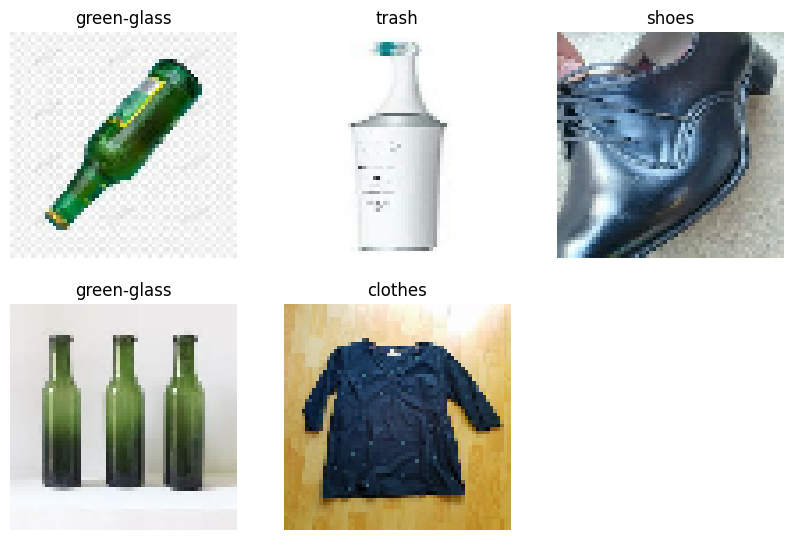

In [744]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(5):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [745]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(50, 64, 64, 3)
(50,)


In [746]:
model = keras.Sequential([
    #keras.layers.Reshape((IMAGE_WIDTH, IMAGE_HEIGHT,3)),
    keras.layers.Normalization(),
    keras.layers.Convolution2D(kernel_size=4, filters=8, padding="same"),
    keras.layers.Convolution2D(kernel_size=4, filters=8, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None),
    keras.layers.Dropout(0.2),
    keras.layers.Convolution2D(kernel_size=4, filters=8, padding="same"),
    keras.layers.Convolution2D(kernel_size=4, filters=8, padding="valid"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(12, activation="softmax")
])

In [798]:
model.compile(optimizer="adam", 
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])
model.build(input_shape=(None,IMAGE_WIDTH,IMAGE_HEIGHT,3))
model.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3)

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_46 (Normaliza  (None, 64, 64, 3)        7         
 tion)                                                           
                                                                 
 conv2d_224 (Conv2D)         (None, 64, 64, 8)         392       
                                                                 
 conv2d_225 (Conv2D)         (None, 64, 64, 8)         1032      
                                                                 
 batch_normalization_2 (Batc  (None, 64, 64, 8)        32        
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 64, 64, 8)         0         
                                                                 
 max_pooling2d_112 (MaxPooli  (None, 32, 32, 8)      

In [748]:
train

<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [749]:
history = model.fit(train, validation_data=validate, epochs=1, batch_size=50,callbacks=[callback])

Epoch 1/100
249/249 [==============================] - 36s 140ms/step - loss: 1.5464 - accuracy: 0.5024 - val_loss: 1.8720 - val_accuracy: 0.4148
Epoch 2/100
249/249 [==============================] - 33s 132ms/step - loss: 1.1832 - accuracy: 0.6029 - val_loss: 1.2794 - val_accuracy: 0.5814
Epoch 3/100
249/249 [==============================] - 33s 132ms/step - loss: 1.0492 - accuracy: 0.6504 - val_loss: 1.4384 - val_accuracy: 0.5111
Epoch 4/100
249/249 [==============================] - 33s 134ms/step - loss: 0.9631 - accuracy: 0.6730 - val_loss: 1.1362 - val_accuracy: 0.6078
Epoch 5/100
249/249 [==============================] - 34s 134ms/step - loss: 0.9063 - accuracy: 0.6950 - val_loss: 0.9979 - val_accuracy: 0.6745
Epoch 6/100
249/249 [==============================] - 33s 133ms/step - loss: 0.8500 - accuracy: 0.7149 - val_loss: 0.9819 - val_accuracy: 0.6752
Epoch 7/100
249/249 [==============================] - 33s 133ms/step - loss: 0.8211 - accuracy: 0.7261 - val_loss: 1.0402 -

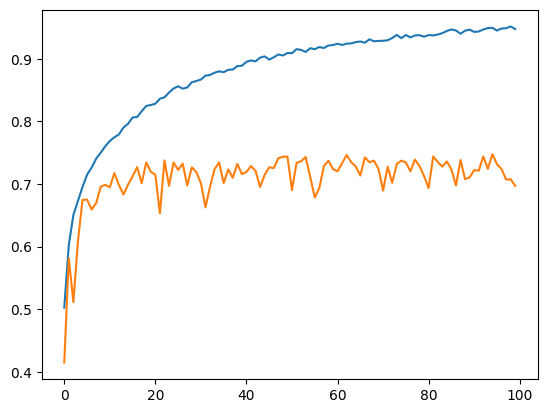

In [750]:
ax = plt.subplot()
ax.plot(history.history["accuracy"], label="Accuracy")
ax.plot(history.history["val_accuracy"], label="Validation Accuracy")

In [751]:
# model.save("./Models/64-max/")

INFO:tensorflow:Assets written to: ./Models/64-max/assets


INFO:tensorflow:Assets written to: ./Models/64-max/assets


In [752]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
# tflite_model = converter.convert()
# with open('model.tflite', 'wb') as f:
#   f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/8h/r_p0xb3j6m57h6qffsf0kmp00000gn/T/tmprz7y64yx/assets


INFO:tensorflow:Assets written to: /var/folders/8h/r_p0xb3j6m57h6qffsf0kmp00000gn/T/tmprz7y64yx/assets
2023-02-11 22:20:05.862694: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-02-11 22:20:05.862717: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-02-11 22:20:05.862843: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/8h/r_p0xb3j6m57h6qffsf0kmp00000gn/T/tmprz7y64yx
2023-02-11 22:20:05.866525: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-02-11 22:20:05.866540: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/8h/r_p0xb3j6m57h6qffsf0kmp00000gn/T/tmprz7y64yx
2023-02-11 22:20:05.878392: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-02-11 22:20:05.985238: I tensorflow/cc/saved_model/loader.cc:213] Running initialization

In [795]:
for images, labels in train.take(1):
    for i in range(1):
        print(images[i].shape)
        #print(model.predict(images[i].numpy().reshape(1, 64,64,3).shape))
        print(categories[np.argmax(model.predict(images[i]))])
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        

(64, 64, 3)


ValueError: in user code:

    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/khaledyasser/Documents/GitHub/Im_not_garbage/.venv/lib/python3.9/site-packages/keras/engine/input_spec.py", line 277, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_46' (type Sequential).
    
    Input 0 of layer "dense_92" is incompatible with the layer: expected axis -1 of input shape to have value 1568, but received input with shape (1, 672)
    
    Call arguments received by layer 'sequential_46' (type Sequential):
      • inputs=tf.Tensor(shape=(32, 64, 3), dtype=float32)
      • training=False
      • mask=None
